
# Credit Card Approval Prediction With Towhee

- [Before You Get Started](#1)
- [Data Processing With Pandas](#2)
- [Building Models with Towhee](#3)
    - [Prepare Training And Testing Data](#4)
    - [Feature Extract](#5)
    - [Model](#6)
        - [Train](#7)
        - [Evaluate](#8)
        - [Ensemble](#9)
- [Improve](#10)
        

In [1]:
import warnings
warnings.filterwarnings("ignore")

<a id="1"></a> <br>
## Before you get started
In this notebook we are about to finish the credit card approval prediction task with pandas and [Towhee](https://towhee.io/). Towhee is an open-source machine learning pipeline that helps you with various machine learning tasks. Make sure you have installed towhee over 0.6.0 before you get started via `pip install towhee`.

You are more than welcome to join our community, together we can make a differnece.

**Github**: [https://github.com/towhee-io/towhee](https://github.com/towhee-io/towhee)

**Slack**: [https://slack.towhee.io](https://slack.towhee.io)

**Twitter**: [https://twitter.com/towheeio](https://twitter.com/towheeio)

In [2]:
pip install towhee

     |████████████████████████████████| 322 kB 515 kB/s            
     |████████████████████████████████| 123 kB 7.8 MB/s            
     |████████████████████████████████| 546 kB 7.8 MB/s            
Note: you may need to restart the kernel to use updated packages.


<a id="2"></a> <br>
## Data Processing With Pandas

First load the data as Dataframe for further processing.

> Data is from [Kaggle](https://www.kaggle.com/code/chizzzy/credit-card-approval-prediction/data?scriptVersionId=92959791), you can download it.

In [3]:
import pandas as pd

record = pd.read_csv("./credit_record.csv", encoding = 'utf-8')
data = pd.read_csv("./application_record.csv", encoding = 'utf-8')

Find the first month that users' data were recorded and rename the column with a more understandable name.

In [4]:
begin_month=pd.DataFrame(record.groupby(["ID"])["MONTHS_BALANCE"].agg(min))
begin_month=begin_month.rename(columns={'MONTHS_BALANCE':'begin_month'}) 

Process the `STATUS` column to find out if candidates have the record of overdue. Here is a table describe what each label stands for:
- X: No loan for the month;
- C: paid off that month;
- 0: 1-29 days past due;
- 1: 30-59 days past due;
- 2: 60-89 days overdue;
- 3: 90-119 days overdue;
- 4: 120-149 days overdue;
- 5: Overdue or bad debts, write-offs for more than 150 days 

In [5]:
record.loc[record['STATUS']=='X', 'STATUS']=-1 
record.loc[record['STATUS']=='C', 'STATUS']=-1 
record.loc[record['STATUS']=='0', 'STATUS']=0 
record.loc[record['STATUS']=='1', 'STATUS']=1
record.loc[record['STATUS']=='2', 'STATUS']=2
record.loc[record['STATUS']=='3', 'STATUS']=3 
record.loc[record['STATUS']=='4', 'STATUS']=4 
record.loc[record['STATUS']=='5', 'STATUS']=5
record.groupby('ID')['STATUS'].max().value_counts(normalize=True)

 0    0.754202
-1    0.129455
 1    0.101838
 2    0.007307
 5    0.004241
 3    0.001914
 4    0.001044
Name: STATUS, dtype: float64

Generally, users in risk should be less than 3%, thus those who overdue for more than 60 days should be marked as risk users.

In [6]:
record.loc[record['STATUS']>=2, 'dep_value']=1
record.loc[record['STATUS']<2, 'dep_value']=0 
temp = record[['ID', 'dep_value']].groupby('ID').sum()
temp.loc[temp['dep_value']!=0, 'dep_value']='Yes'
temp.loc[temp['dep_value']==0, 'dep_value']= 'No'
temp.value_counts(normalize=True)

dep_value
No           0.985495
Yes          0.014505
dtype: float64

Merge the information into one dataframe, and mark those risk users with target `1` while other users `0`. We will regard the `target` column as result. Meanwhile, we should drop those rows with missing values to avoid disturb.

In [7]:
new_data=pd.merge(data,begin_month,how="left",on="ID")
new_data=pd.merge(new_data, temp,how='inner',on='ID')
new_data['target']=new_data['dep_value']
new_data.loc[new_data['target']=='Yes','target']=1
new_data.loc[new_data['target']=='No','target']=0

In [8]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
new_data.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,begin_month,dep_value,target
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-15.0,No,0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-14.0,No,0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,-29.0,No,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-4.0,No,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-26.0,No,0


Before we get started, we should take a rough look at our samples, in case inbalanced data leading to a weird result.

In [9]:
new_data = new_data.dropna()
new_data['target'].value_counts()

0    24712
1      422
Name: target, dtype: int64

Obviously the data are extremely in balance, so we'll need to resample the data.

In [10]:
from imblearn.over_sampling import SMOTEN
X = new_data[['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'FLAG_MOBIL',
       'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'begin_month','dep_value']]
y = new_data['target'].astype('int')
X_balance,y_balance = SMOTEN().fit_resample(X, y)
X_balance = pd.DataFrame(X_balance, columns = X.columns)
X_balance.insert(0, 'target', y_balance)
new_data = X_balance

<a id="3"></a> <br>
## Building Models with [Towhee](https://towhee.io/) 

In the following part, we will use Towhee's DataCollection API to deal with the processed data. DataCollection provides a series API to support training, prediction, and evaluating with machine learning models.

Also, Towhee has encapsulated several models as built-in operators, which we will introduce in the following training part.

<a id="4"></a> <br>
### Prepare Training And Testing Data

Users can use `from_df` to load data from a dataframe then split the data into training set and test set with `split_train_test`, the ratio is 9:1 by default.

In [11]:
import towhee
out = towhee.from_df(new_data).unstream()
out = (
    out.runas_op['DAYS_BIRTH', 'years_birth'](func=lambda x: -int(x)//365)
        .runas_op['DAYS_EMPLOYED', 'years_employed'](func=lambda x: -int(x)//365)
)
train, test = out.split_train_test()

Another important API is `runas_op`, which enables users running self-defined functions as operators effortless.

In the example above, we defined a lambda function to calculate age and work experience (years) from given info (days), and feed it to `runas_op`. In this way, DataCollection will wrap and register it as an operator and execute.

Note that the content inside the `[]` are the input and output columns, i.e. input column is `DAYS_BIRTH` and the output will be stored in `age`. This is a tricky part in DataCollection design. In many cases we might need to process some columns inside DataCollection, so we introduced `[]` to tell the DC which columns we are dealing with. 

Usage:
- Single input Single output: `['input', 'output']`
- Single input Multi outputs: `['input', ('output_1, output_2')]`
- Multi inputs Single output: `[('input_1', 'input_2'), 'output']`
- Multi inputs Multi outputs: `[('input_1', 'input_2'), ('output_1, output_2')]`

<a id="5"></a> <br>
### Feature Extract

Then we need to process some data, include:
- Discretize the numerical data, both continuous data and binary data;
- Encode categorical data with non-digital value;
- Stack chosen features into a feature tensor;

In [12]:
def feature_extract(dc):
    return (
        dc.num_discretizer['CNT_CHILDREN', 'childnum'](n_bins=3)
        .num_discretizer['AMT_INCOME_TOTAL', 'inc'](n_bins=5)
        .num_discretizer['years_birth', 'age'](n_bins=5)
        .num_discretizer['years_employed', 'worktm'](n_bins=5)
        .num_discretizer['CNT_FAM_MEMBERS', 'fmsize'](n_bins=5)
        .cate_one_hot_encoder['NAME_INCOME_TYPE', 'inctp']()
        .cate_one_hot_encoder['OCCUPATION_TYPE', 'occyp']()
        .cate_one_hot_encoder['NAME_HOUSING_TYPE', 'houtp']()
        .cate_one_hot_encoder['NAME_EDUCATION_TYPE', 'edutp']()
        .cate_one_hot_encoder['NAME_FAMILY_STATUS', 'famtp']()
        .cate_one_hot_encoder['CODE_GENDER', 'gender']()
        .cate_one_hot_encoder['FLAG_OWN_CAR', 'car']()
        .cate_one_hot_encoder['FLAG_OWN_REALTY', 'realty']()
        .tensor_hstack[('childnum', 'inc', 'age', 'worktm', 'fmsize',
                        'inctp', 'occyp', 'houtp', 'edutp', 'famtp',
                        'gender', 'car', 'realty'), 'fea']()
    )

<a id="6"></a> <br>
### Model

Towhee encapsulates several machine learning models as built-in operators so that users can easily access to. In this tutorial, we will user logistic regression, decision tree, and support vector machine.

<a id="7"></a> <br>
#### Train

Before trainging the model, make sure the DataCollection is set to training mode with `dc.set_training()`.

To train a model, Let's take logistic regression as an example:

```logistic_regression[('feature', 'actual_result'), 'predict_result'](name = 'model_name', kwargs)```

- logistic_regression is the operator name of the built-in algorithm;
- The `[]` specifies the input and output columns;
- Each model requires a unique name, so as to load its state and predict with it in the coming step;
- kwargs are the arguements of the model, they are exactly same as sklearn models.

In [13]:
train = feature_extract(train.set_training())

In [14]:
train.logistic_regression[('fea', 'target'), 'lr_predict'](name = 'logistic', max_iter=10) \
    .decision_tree[('fea', 'target'), 'dt_predict'](name = 'decision_tree', splitter = 'random', max_depth = 10) \
    .svc[('fea', 'target'), 'svm_predict'](name = 'svm_classifier', C = 0.8, kernel='rbf', probability=True)

<a id="8"></a> <br>
#### Evaluate

In [15]:
test = feature_extract(test.set_evaluating(train.get_state()))

The trained models are ready and the states are properly stored, we can predict with them and see how they works.

First, make sure the DC is set to evaluating mode. Then we can run prediction with exact same API as training. There are serval points to pay attention to:
- When `set_evaluating()`, we need to pass the `_state` of the DataCollection `train` we trained in previous step where all the model states are stored in;
- Make sure your model name is same as the one you trained. As we said, a model's name is the unique identifier. A user might train several logistic regression models with different names, and evaluate with different lr model by specifying different names;
- `with_metrics` function allow users to clarify the metrics they are interested in;


,accuracy,recall,confusion_matrix
lr,0.743476,0.743476,
dt,0.883472,0.883472,
svm,0.978556,0.978556,

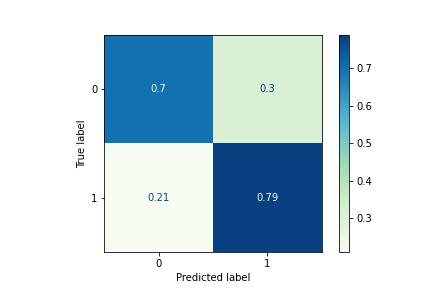
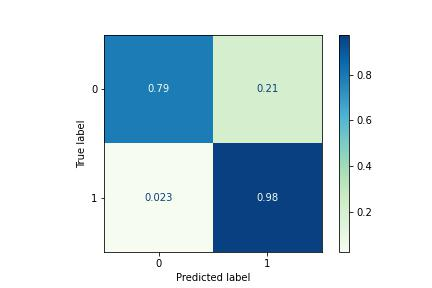
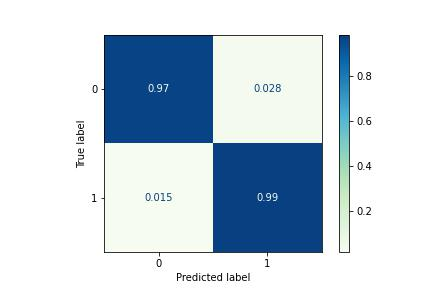

In [16]:
metrics = test.set_evaluating(train._state) \
    .logistic_regression[('fea', 'target'), 'lr_predict'](name='logistic') \
    .decision_tree[('fea', 'target'), 'dt_predict'](name='decision_tree') \
    .svc[('fea', 'target'), 'svm_predict'](name='svm_classifier') \
    .with_metrics(['accuracy', 'recall', 'confusion_matrix']) \
    .evaluate['target', 'lr_predict']('lr') \
    .evaluate['target', 'dt_predict']('dt') \
    .evaluate['target', 'svm_predict']('svm') \
    .report()

<a id="9"></a> <br>
#### Ensemble

Towhee also support self-defined algorithm operators, here is a example of xgboost classifier we present to ensemble the results from logistic regression, decision tree and support vector machine.
- Use `register` decorator to register your operator for future calling;
- All the model operators should be a subclass of `StatefulOperator` with a name;
- a `fit` function and `predict` function is required;

In [17]:
from towhee import register
from towhee.operator import StatefulOperator
from xgboost import XGBClassifier
from scipy import sparse
import numpy as np

@register
class XGBClassifierOperator(StatefulOperator):
    def __init__(self, name):
        super().__init__(name=name)
    
    def fit(self):
        X = sparse.vstack(self._data[0])
        y = np.array(self._data[1]).reshape([-1, 1])
        self._state.model = XGBClassifier(n_estimators=100)
        self._state.model.fit(X, y)
        
    def predict(self, *arg):
        return self._state.model.predict(arg[0])[0]

Stack the prediction results from lr, dt and svm into a new feature as the input of our ensemble model.

In [18]:
for i in ['lr_predict', 'dt_predict','svm_predict']:
	train.runas_op[i,i](func=lambda x: x[0])
	test.runas_op[i,i](func=lambda x: x[0])

train = train.tensor_hstack[('lr_predict', 'dt_predict','svm_predict'), 'ensemble_predict']()
test = test.tensor_hstack[('lr_predict', 'dt_predict', 'svm_predict'), 'ensemble_predict']()

[02:46:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,accuracy,recall,confusion_matrix
xgb,0.978758,0.978758,

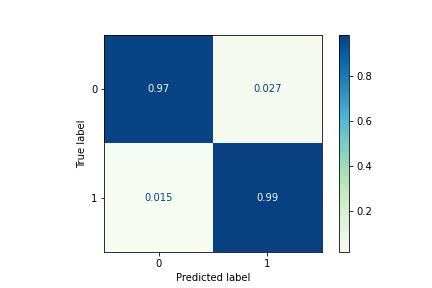

In [19]:
train.set_training().XGBClassifierOperator[('ensemble_predict', 'target'), 'xgb_predict'](name='XGBClassifierOperator')

metrics = test.set_evaluating(train._state) \
    .XGBClassifierOperator[('ensemble_predict', 'target'), 'xgb_predict'](name='XGBClassifierOperator') \
    .with_metrics(['accuracy', 'recall', 'confusion_matrix']) \
    .evaluate['target', 'xgb_predict']('xgb') \
    .report()

<a id="10"></a> <br>
## Improve

The result from previous process is not extremely satsifying, so we can futher improve the performance by analysing the features. DC provides a `feature_summarize` API to help understanding data. Then we should extract these feature according to their pattern to discretize properly.

In [20]:
train.feature_summarize['CNT_CHILDREN', 'AMT_INCOME_TOTAL','CNT_FAM_MEMBERS', 'years_birth', 'years_employed'](target='target')

Variable: CNT_CHILDREN's IV sum is: 0.17517426069063458
Variable: AMT_INCOME_TOTAL's IV sum is: 0.6377763155272913
Variable: CNT_FAM_MEMBERS's IV sum is: 0.15635342524237256
Variable: years_birth's IV sum is: 0.8612574247923361
Variable: years_employed's IV sum is: 0.27022981571426363


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,CNT_CHILDREN,0.0,32123,14060,18063,0.722174,0.562307,0.632308,0.812003,-0.250127,0.044947
1,CNT_CHILDREN,1.0,8234,5430,2804,0.185113,0.340539,0.244199,0.126051,0.661297,0.078131
2,CNT_CHILDREN,2.0,3543,2403,1140,0.079652,0.321761,0.108068,0.051247,0.746094,0.042393
3,CNT_CHILDREN,3.0,507,270,237,0.011398,0.467456,0.012142,0.010654,0.130766,0.000195
4,CNT_CHILDREN,4.0,55,54,1,0.001236,0.018182,0.002428,0.000045,3.989389,0.009509
...,...,...,...,...,...,...,...,...,...,...,...
38,years_employed,38.0,11,11,0,0.000247,0.000000,0.000495,0.000000,0.000000,0.000000
39,years_employed,39.0,10,10,0,0.000225,0.000000,0.000450,0.000000,0.000000,0.000000
40,years_employed,40.0,15,15,0,0.000337,0.000000,0.000675,0.000000,0.000000,0.000000
41,years_employed,42.0,3,3,0,0.000067,0.000000,0.000135,0.000000,0.000000,0.000000


The table summarize the values of the columns listed in `[]`:
- `All`: number of this value appeared in this column;
- `Good`: number of this value in this column with `target` labelled '0';
- `Bad`: number of this value in this column with `target` labelled '1';
- `Share`: the ratio of this value in this column;
- `Bad Rate`: `Bad`/`All`;
- `Distribution Good`: `Good`/ number of `target` labelled '0';
- `Distribution Bad`: `Bad`/ number of `target` labelled '1';
- `WoE`:  Weight of Evidence $$wo{e_i} = \ln {{{P_{yi}}} \over {{P_{ni}}}} = \ln {{{y_i}/{y_s}} \over {{n_i}/{n_s}}}$$
$wo{e_i}$ is the I category's WOE value. ${{P_{yi}}}$ is the proportion of the positive samples in this category to all positive samples.   ${{P_{ni}}}$ is the ratio of negative samples (${{n_i}}$) in this class to all negative samples (${{n_s}}$).

- `IV`: Information Value, measures the variable's ability to predict. $$I{V_i} = ({P_{yi}} - {P_{ni}}) \times wo{e_i}$$  
The IV values of the various types are the difference between the conditional positive rate and the conditional negative rate multiplied by the WOE value of the variable. The total IV value of the variable can be understood as the weighted sum of the conditional positive rate and the conditional negative rate difference:
$$IV = \sum\limits_i^n {I{V_i}} $$  

